## Sztuczne sieci neuronowe - laboratorium 13

In [12]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

### Przygotowanie danych

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)

val_dataset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

100%|██████████| 26421880/26421880 [00:12<00:00, 2174005.14it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 922280.04it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1851601.66it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 2572346.56it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

#### Ćwiczenie
Uruchom poniższą funkcję, aby zwizualizować przykładowe obrazki ze zbioru FashionMNIST.

In [5]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

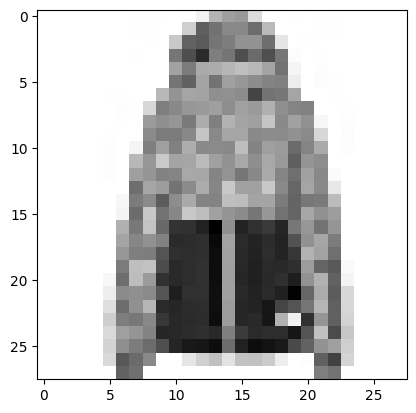

In [8]:
matplotlib_imshow(train_dataset[22][0], True)

### Definicja modelu

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Tensorboard

Tensorboard w PyTorchu używa się z wykorzystaniem klasy `SummaryWriter`.  
Potrzebny jest katalog, w którym będą zapisywane logi (domyslnie "runs").
W momencie uruchomienia odpowiedniej metody do pliku z logami zapisywane są odpowiednie elementy.

Tensorboard uruchamia się z poziomu konsoli: `tensorboard --logdir=ŚCIEŻKA_DO_KATALOGU` i działa się w przeglądarce (domyślnie port 6006).

https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter

#### Ćwiczenie

Stwórz `SummaryWriter` i zapisz do pliku z logami cztery obrazki ze zbioru uczącego (`img_grid` poniżej).

In [15]:
writer = SummaryWriter()

images, labels = next(iter(train_loader))
img_grid = torchvision.utils.make_grid(images)

writer.add_image('images', img_grid)
writer.close()

#### Ćwiczenie

W Tensorboard można tez wizualizować modele. Wykorzystaj do tego metodę `add_graph`. Jako drugi argument podaj `images`.

In [21]:
writer = SummaryWriter()
images, labels = next(iter(train_loader))
img_grid = torchvision.utils.make_grid(images)
writer.add_image('images', img_grid)
writer.add_graph(model, images)
writer.close()


### Tensorboard w trakcie treningu

In [22]:
# helper functions
classes = train_dataset.classes

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

#### Ćwiczenie
Uzupełnij poniższy kod, aby co 1000 iteracji zapisać wartość funkcji straty oraz zwizualizować predykcje dla aktualnego batcha (użyj `plot_classes_preds`).

In [23]:
writer = SummaryWriter()
running_loss = 0.0
for i, data in enumerate(train_loader):

    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:    # every 1000 mini-batches...
        print(f"Iteration {i+1}")

        # ...log the running loss
        # TU WPISZ KOD
        writer.add_scalar('training loss',
                            running_loss / 1000,
                            i+1)
        # ...log a Matplotlib Figure showing the model's predictions on a
        # random mini-batch
        # TU WPISZ KOD
        writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=i+1)
                            
        running_loss = 0.0
print('Finished Training')
writer.close()

Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Finished Training


#### Ćwiczenie
Zwizualizuj w Tensorboard krzywą precision-recall na zbiorze walidacyjnym (dla wytrenowanego modelu).  
(na podstawie https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)

In [25]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        output = model(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer = SummaryWriter()
    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

#### Zadanie domowe

Wkomponiuj Tensorboard (`SummaryWriter`) w inny kod, np. z poprzednich ćwiczeń / wykładu / projektu. Wyślij prowadzącemu screenshot jako dowód wykonania zadania.